In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from math import sqrt
import pandas_profiling

import env
import acquire
import prep
import explore_final
import scipy.stats as stats
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from statsmodels.formula.api import ols

## Initial Hypothesis

Square footage and home value extremes are leading drivers of log error.

## Acquire and summarize data

Initial Dataframe included single family residence homes with 40+ initial fields brought in.

After reviewing the data for missing values, multicollinearity, and low correlation we dropped our data down to 14 columns and 54,000 rows. 300 values were imputed on lotsizesquarefeet with the mean in order to maintain the column.

In [2]:
#nmysql query single family residence from zillow DB
df = prep.prep_df()

In [3]:
df.shape

(54544, 14)

## Data prep and test/train split

Our initial dataframe was split into 70/30 train/test adding a tax_per_sqft field. Random State 123 was used.

In [4]:
#train test split and adding a tax_per_sqft field
train, test = prep.get_train_and_test(df)

In [5]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft
16758,3.0,3.0,1992.0,807953.0,6037.0,33785071.0,-118361341.0,13164.0,33727.0,3101.0,96121.0,1957.0,280691.0,-0.050721,405.598896
31827,3.5,4.0,2598.0,689028.0,6059.0,33817922.0,-118023852.0,4067.0,44833.0,1286.0,96185.0,2009.0,363039.0,0.000668,265.214781


In [6]:
#further cleanup for X/y train/test
X_train = train.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_train = train[['logerror']]
X_test = test.drop(columns=['logerror','fips','latitude','longitude','regionidcity','regionidcounty','regionidzip'])
y_test = test[['logerror']]
X_train.tax_value = X_train.tax_value /1000
X_train.structuretaxvaluedollarcnt = X_train.structuretaxvaluedollarcnt/1000


In [7]:
X_train, y_train, X_test, y_test = prep.get_baseline_train_test_split(df)

In [8]:
X_train.head(2)

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt
16758,3.0,3.0,1992.0,807953.0,13164.0,1957.0,280691.0
31827,3.5,4.0,2598.0,689028.0,4067.0,2009.0,363039.0


## Initial exploration and feature selection

In [9]:
#adding a baseline yhat as mean of log error and residual amt based off that.
train['mean_logerror'] = train.logerror.mean()
train['residual'] = train['logerror']- train['mean_logerror']

In [10]:
train.head(2)

,bathrooms,bedrooms,sqft,tax_value,fips,latitude,longitude,lotsizesquarefeet,regionidcity,regionidcounty,regionidzip,yearbuilt,structuretaxvaluedollarcnt,logerror,tax_per_sqft,mean_logerror,residual
16758,3.0,3.0,1992.0,807953.0,6037.0,33785071.0,-118361341.0,13164.0,33727.0,3101.0,96121.0,1957.0,280691.0,-0.050721,405.598896,0.016126,-0.066847
31827,3.5,4.0,2598.0,689028.0,6059.0,33817922.0,-118023852.0,4067.0,44833.0,1286.0,96185.0,2009.0,363039.0,0.000668,265.214781,0.016126,-0.015457


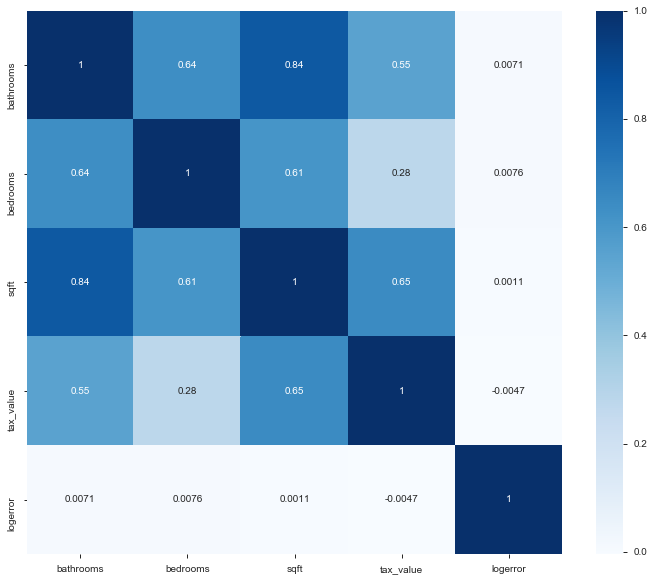

In [11]:
# Heatmap of possible initial features
plt.figure(figsize=(12,10))
subset = train[['bathrooms','bedrooms','sqft','tax_value','logerror']]
cor = subset.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Blues)
plt.show()

## Initial Baseline score

In [12]:
baseline = mean_squared_error(train.logerror,train.mean_logerror)
print(baseline)

0.02817990868067973


## MVP

After some basic feature engineering and selection we trained the new model on just sqft and bedrooms. This model performed slightly better than our baseline.

In [13]:
#MSE of sqft and bedrooms as x variables
x = train[['sqft','bedrooms']]
y = train[['logerror']]
ols_model = ols('y ~ x', data=train).fit()
train['yhat'] = ols_model.predict(x)

In [14]:
model1 = mean_squared_error(train.logerror,train.yhat)
print(model1)
model1 < baseline

0.02817772389257862


True

## Exploration

We began our exploration by clustering on the y variable.

In [15]:
#Clustered by logerror
train = explore_final.target_cluster(y_train,X_train)

In [16]:
train.groupby('cluster').mean().sort_values(by='logerror')

,bathrooms,bedrooms,sqft,tax_value,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,logerror
cluster,,,,,,,,
0,2.244240,3.305924,1860.756482,454767.992505,10029.317986,1960.929099,176271.703157,-0.007381
1,2.295644,3.333333,1909.116495,468944.329907,10045.913491,1961.077827,191703.552922,0.328907
2,2.213043,3.347826,1762.452174,377397.782609,7377.413658,1958.886957,143870.252174,1.822684
